In [1]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import shgo
from scipy.optimize import NonlinearConstraint as NLC
from scipy.optimize import LinearConstraint as LC

import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

In [2]:
# The differentiable kernel function with parameters c,l not filled.
def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return c * np.exp(-(np.linalg.norm(x1-x2+small_sig,axis = -1)**2) / l)

def GPMI(x,c,l,var_0):# The mutual information for a GP.
    x = x.reshape(-1,2)
    KA = k(x[:,np.newaxis,:],x,c,l)
    if var_0>0:
        return 1/2*np.log(np.linalg.det(np.eye(len(KA))+(1/var_0)*KA ))
    else:
        return 1/2*np.log(np.linalg.det(KA))

In [223]:
def step_diff(z,i):
    return np.linalg.norm(z.reshape(-1,2)[i,:]-z.reshape(-1,2)[i-1,:])

In [224]:

T = 10

c = 1
l = 1
var_0 = 0.01
objective = lambda z: -GPMI(z,c=c,l=l,var_0=var_0)


search_region_center = np.array([0,0])
search_region_radius = 3

search_region_constraints = [NLC(fun = partial( lambda z,i: np.linalg.norm(z.reshape(-1,2)[i,:]-search_region_center),i=i),\
                                 lb=0, ub=search_region_radius) for i in range(T)]

step_size = 1

step_size_constraints  = [NLC(fun = partial(step_diff,i=i),lb=0,ub=step_size) for i in range(1,T)]

x_ref = np.zeros(2*T)
x_ref[:2]=np.array([0,0])
initial_pos_constraint = [LC(A=np.diag([1,1]+[0 for i in range(2*(T-1))]),lb=x_ref,ub=x_ref)]

# Trust region with bounded location constraints only

In [13]:
tr_result = minimize(objective,x0=np.zeros(2*T),method = 'trust-constr',\
#                      constraints = step_size_constraints+initial_pos_constraint+search_region_constraints,\
                     constraints = search_region_constraints
                    )

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [22]:
sols = {'TR under Bounded Location Constraints': tr_result['x'].reshape(-1,2)}


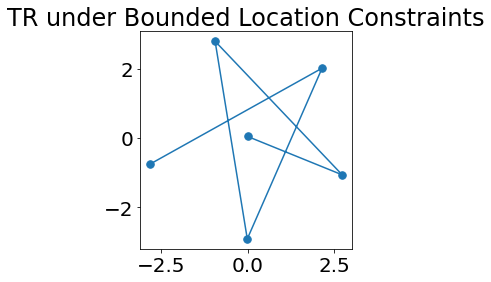

In [23]:

plt.rc('font',size=20)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15)
    
    plt.title(key)
    plt.gca().set_aspect('equal')

#     ll.labelLines(plt.gca().get_lines(),fontsize=20,zorder=3,yoffsets=0.2,align=False)
    plt.show()

# Trust region with step size constraints only

In [42]:
tr_result = minimize(objective,x0=np.zeros(2*T),method = 'trust-constr',\
                     constraints = step_size_constraints+initial_pos_constraint,\
#                      constraints = search_region_constraints
                    )

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [43]:
sols = {'TR under Step Size Constraints': tr_result['x'].reshape(-1,2)}


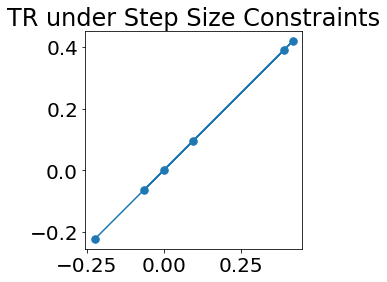

In [44]:

plt.rc('font',size=20)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15)
    
    plt.title(key)
    plt.gca().set_aspect('equal')

#     ll.labelLines(plt.gca().get_lines(),fontsize=20,zorder=3,yoffsets=0.2,align=False)
    plt.show()

In [45]:
tr_result['constr']

[array([0.55369228]),
 array([0.64291808]),
 array([0.68163326]),
 array([0.45695997]),
 array([0.45072434]),
 array([1.22649153e-30, 1.11808225e-30, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])]

In [46]:
tr_result['x'].reshape(-1,2)

array([[ 1.22649153e-30,  1.11808225e-30],
       [ 3.91519566e-01,  3.91519566e-01],
       [-6.30921655e-02, -6.30921655e-02],
       [ 4.18895333e-01,  4.18895333e-01],
       [ 9.57758360e-02,  9.57758360e-02],
       [-2.22934403e-01, -2.22934403e-01]])

In [80]:
tr_result['fun']

-6.448015796968061

# Random search under step size constraint

In [147]:
best_xs = []
best_val = 0

for _ in range(20000):
    rs = np.random.rand(T-1)*step_size
    thetas = np.random.rand(T-1)*2*np.pi

    x0 = np.array([0,0])
    xs = (rs*np.array([np.cos(thetas),np.sin(thetas)])).T

    xs = np.vstack([x0,xs])

    xs = np.cumsum(xs,axis=0)
    val = objective(xs)
    
#     print(np.linalg.norm(xs[1:]-xs[:-1],axis=1))
    
    if val<best_val:
        best_xs = xs
        best_val=val

In [148]:
best_val

-1.3207598866831379e+01

In [149]:
straight_line = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size

In [150]:
objective(straight_line)

-1.3450590389426255e+01

In [151]:
sols = {'Random Search': best_xs,'Straightline':straight_line}


/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=-2.2514596680314205e+00, xmax=0.0, xval=2.5707610112094743). Clipping it into the allowed range.
  warnings.warn(


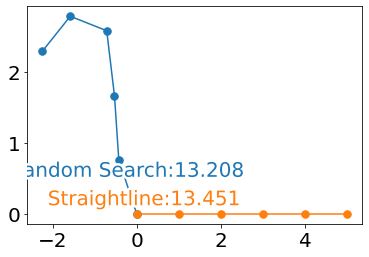

In [152]:

plt.rc('font',size=20)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}:{:.3f}".format(key,-objective(val)))
    
#     plt.gca().set_aspect('equal')

ll.labelLines(plt.gca().get_lines(),fontsize=20,zorder=3,yoffsets=0.2,align=False)
plt.show()

# Random search under bounded location constraint

In [154]:
best_xs = []
best_val = 0
x0 = np.array([0,0])
    
for _ in range(20000):
    rs = np.random.rand(T)*search_region_radius
    thetas = np.random.rand(T)*2*np.pi

    xs = x0+(rs*np.array([np.cos(thetas),np.sin(thetas)])).T

    val = objective(xs)
        
    if val<best_val:
        best_xs = xs
        best_val=val

In [155]:
best_val

-1.3845262346535584e+01

In [156]:
straight_line = np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size

In [157]:
objective(straight_line)

-1.3450590389426255e+01

In [160]:
sols = {'Random Search': best_xs
#         ,'Straightline':straight_line
       }


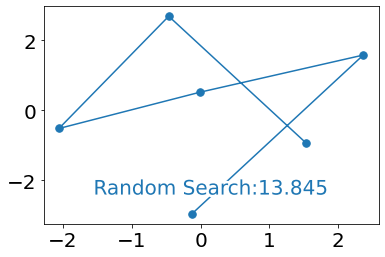

In [163]:

plt.rc('font',size=20)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}:{:.3f}".format(key,-objective(val)))
    
#     plt.gca().set_aspect('equal')

ll.labelLines(plt.gca().get_lines(),fontsize=20,zorder=3,yoffsets=0.2,align=False)
plt.show()

# Random search under bounded location constraint + step size constraint

In [250]:
def rand_search(x0,R,step_size,fix_step_size=False):
    best_xs = []
    best_val = 0
    
    for _ in range(50000):

        xs = [x0]
        for i in range(T-1):

            cand_x = 0
            while True:

                r = np.random.rand()*step_size
                if fix_step_size:
                    r = step_size

                theta = np.random.rand()*2*np.pi

                cand_x = xs[-1]+r*np.array([np.cos(theta),np.sin(theta)])

                if np.linalg.norm(cand_x-x0)<=R:
                    break

            xs.append(cand_x)

        xs = np.array(xs)
        val = objective(xs)

        if val<best_val:
            best_xs = xs
            best_val=val
            
    return best_xs,best_val

In [277]:
fix_step,_ = rand_search(search_region_center,\
                         np.inf,\
                         step_size,fix_step_size=True)

In [278]:
var_step,_ = rand_search(search_region_center,\
                         np.inf,\
                         step_size,fix_step_size=False)

In [279]:
tr_result = minimize(objective,x0=fix_step.ravel(),method = 'trust-constr',\
                     constraints = step_size_constraints+initial_pos_constraint+search_region_constraints,\
#                      constraints = search_region_constraints
                    )

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [280]:
sols = {'Random Search': fix_step,
#         'Variable Stepsize':var_step,
        'Straight Line': np.array([np.arange(T)*step_size,np.zeros(T)]).T*step_size
#         ,'Trust Region': tr_result['x'].reshape(-1,2)
       }


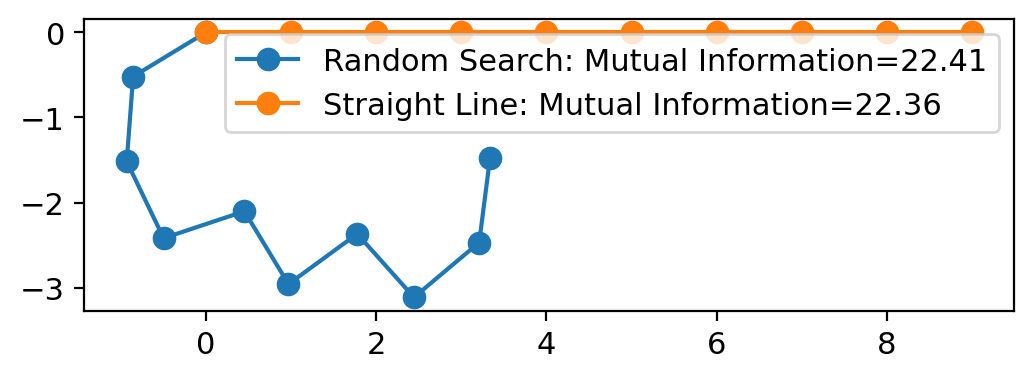

In [281]:

plt.rc('font',size=11)
plt.figure(dpi=200)
for key,val in sols.items():
    plt.plot(val[:,0],val[:,1],marker = '.',markersize = 15,label="{}: Mutual Information={:.2f}".format(key,-objective(val)))
    
    plt.gca().set_aspect('equal')

# circ = plt.Circle(search_region_center,search_region_radius,label='Search Region Boundary',fill=False)
# plt.gca().add_patch(circ)
# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.legend()
plt.show()